In [1]:
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.cluster import HDBSCAN

from util.constants import (
    INCIDENT_CATS_MISC,
    INCIDENT_CATS_NARCOTICS,
    INCIDENT_CATS_SEX_ASSAULT_GENDER,
    INCIDENT_CATS_VIOLENCE,
)
from util.general import list_to_parsed_set

In [2]:
all_df = pl.read_csv(
    "./data/incident_dump.csv",
).with_columns(
    pl.col("reported")
    .str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z")
    .dt.convert_time_zone("America/Chicago"),
    pl.col("reported_date").str.to_date("%Y-%m-%d"),
    pl.col("validated_location").str.split(",").cast(pl.List(pl.Float64)),
    pl.col("validated_location")
    .str.split(",")
    .cast(pl.List(pl.Float64))
    .apply(lambda v: v[1])
    .alias("longitude"),
    pl.col("validated_location")
    .str.split(",")
    .cast(pl.List(pl.Float64))
    .apply(lambda v: v[0])
    .alias("latitude"),
)
all_df = all_df.filter(~pl.col("validated_address").is_null()).filter(
    pl.col("incident") != "Information"
)

In [3]:
type_set = list_to_parsed_set(all_df["incident"].to_list())
type_set.remove("Information")
print(len(type_set))

301


In [4]:
VIOLENCE = INCIDENT_CATS_VIOLENCE
SEXUAL_ASSAULT_GENDER_BASED = INCIDENT_CATS_SEX_ASSAULT_GENDER
NARCOTICS = INCIDENT_CATS_NARCOTICS
OTHER = INCIDENT_CATS_MISC

print(len(VIOLENCE))
print(len(SEXUAL_ASSAULT_GENDER_BASED))
print(len(NARCOTICS))

68
26
21


In [5]:
categorized_total = []
categorized_total.extend(VIOLENCE)
categorized_total.extend(SEXUAL_ASSAULT_GENDER_BASED)
categorized_total.extend(NARCOTICS)
categorized_total.extend(OTHER)

# To make sure that all values are categorized
print(type_set.difference(set(categorized_total)))

In [8]:
CLUSTER_KEY = "hdb_cluster"
VIEWPORT_X = (-87.63, -87.56)
VIEWPORT_Y = (41.77, 41.832)


def contains_violence(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in VIOLENCE:
            return True
    return False


def contains_sa_gb(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in SEXUAL_ASSAULT_GENDER_BASED:
            return True
    return False


def contains_narcotics(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in NARCOTICS:
            return True
    return False


def hdbscan_plotting(df: gp.GeoDataFrame, title_suffix: str) -> None:
    point_array = np.array(
        [
            (point.y, point.x)
            for point in df.to_crs(crs=f"EPSG:{ESPG_NUM}").geometry
        ]
    )

    print(point_array.shape)

    min_cluster_size = max(int(df.shape[0] * 0.05), 7)
    # min_samples = int(df.shape[0] * 0.02)

    hdb = HDBSCAN(min_cluster_size=min_cluster_size).fit(point_array)
    hdb_labels = [str(label) for label in hdb.labels_]

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(hdb_labels)) - (1 if "-1" in hdb_labels else 0)
    n_noise_ = list(hdb_labels).count("-1")

    print(f"Estimated number of clusters for {title_suffix} {n_clusters_}")
    print(
        f"Estimated number of noise points for {title_suffix} {n_noise_}/{point_array.shape[0]}"
    )

    df[CLUSTER_KEY] = hdb_labels
    gb_df = df[df.hdb_cluster != "-1"]

    hdb_fig, hdb_ax = plt.subplots(figsize=FIGURE_SIZE)
    chi_communities.to_crs(epsg=ESPG_NUM).plot(
        ax=hdb_ax, color="none", edgecolor="black"
    )
    chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=hdb_ax, color="grey")
    df.plot(ax=hdb_ax, markersize=20, color="darkgrey")
    gb_df.plot(
        column=CLUSTER_KEY,
        ax=hdb_ax,
        cmap="viridis",
        legend=True,
        markersize=30,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
    )
    hdb_ax.set_xlim(-87.63, -87.56)
    hdb_ax.set_ylim(41.77, 41.832)
    plt.title(
        f"HDBSCAN for {title_suffix.title().replace('And', 'and')}", fontsize=25
    )
    plt.savefig(f"{title_suffix.replace(' ', '-')}.png")

In [9]:
all_df.filter(pl.col("incident").apply(contains_violence)).head()

shape: (5, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ comments  ┆ dispositi ┆ incident  ┆ location  ┆ … ┆ validated ┆ validated ┆ longitude ┆ latitude │
│ ---       ┆ on        ┆ ---       ┆ ---       ┆   ┆ _address  ┆ _location ┆ ---       ┆ ---      │
│ str       ┆ ---       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ str       ┆           ┆           ┆   ┆ str       ┆ list[f64] ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ An        ┆ Referred  ┆ Informati ┆ 4104 S.   ┆ … ┆ 4104 S    ┆ [41.81975 ┆ -87.60254 ┆ 41.81975 │
│ unknown   ┆           ┆ on /      ┆ Ellis     ┆   ┆ ELLIS     ┆ 3, -87.60 ┆           ┆ 3        │
│ suspect,  ┆           ┆ Armed     ┆ Ave.      ┆   ┆ AVE,      ┆ 254]      ┆           ┆          │
│ armed     ┆           ┆ Robbery   ┆ (Public   ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│ with a…   ┆           ┆           ┆ Way)      ┆   ┆ IL, 6…    ┆           ┆           ┆          │
│ Vehicle   ┆ Open      ┆ Traffic   ┆ 5932 S.   ┆ … ┆ 5932 S    ┆ [41.78567 ┆ -87.59640 ┆ 41.78567 │
│ in        ┆           ┆ Crash /   ┆ Woodlawn  ┆   ┆ WOODLAWN  ┆ 3, -87.59 ┆ 1         ┆ 3        │
│ traffic   ┆           ┆ Hit and   ┆ Ave.      ┆   ┆ AVE,      ┆ 6401]     ┆           ┆          │
│ was       ┆           ┆ Run / Pr… ┆ (Public   ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│ struck    ┆           ┆           ┆ Wa…       ┆   ┆ IL…       ┆           ┆           ┆          │
│ by…       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A visitor ┆ Arrest    ┆ Battery   ┆ 5730 S.   ┆ … ┆ 5730 S    ┆ [41.79123 ┆ -87.60381 ┆ 41.79123 │
│ struck a  ┆           ┆           ┆ Drexel    ┆   ┆ DREXEL    ┆ 8, -87.60 ┆ 5         ┆ 8        │
│ UCM staff ┆           ┆           ┆ Ave.      ┆   ┆ AVE,      ┆ 3815]     ┆           ┆          │
│ mem…      ┆           ┆           ┆ (Comer    ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│           ┆           ┆           ┆ Hospi…    ┆   ┆ IL, …     ┆           ┆           ┆          │
│ A         ┆ Ex.       ┆ Battery   ┆ 5656 S.   ┆ … ┆ 5656 S    ┆ [41.79213 ┆ -87.60503 ┆ 41.79213 │
│ combative ┆ Cleared   ┆           ┆ Maryland  ┆   ┆ MARYLAND  ┆ 4, -87.60 ┆ 3         ┆ 4        │
│ patient   ┆           ┆           ┆ Ave.      ┆   ┆ AVE,      ┆ 5033]     ┆           ┆          │
│ spit on a ┆           ┆           ┆ (UCMED)   ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│ UC…       ┆           ┆           ┆           ┆   ┆ IL…       ┆           ┆           ┆          │
│ An        ┆ CPD       ┆ Informati ┆ 1400 E.   ┆ … ┆ 1400 E    ┆ [41.80974 ┆ -87.59235 ┆ 41.80974 │
│ unknown   ┆           ┆ on /      ┆ 47th St.  ┆   ┆ 47TH ST,  ┆ 7, -87.59 ┆ 4         ┆ 7        │
│ suspect   ┆           ┆ Armed     ┆ (Dunkin   ┆   ┆ CHICAGO,  ┆ 2354]     ┆           ┆          │
│ entered   ┆           ┆ Robbery   ┆ Donuts)   ┆   ┆ IL, 606…  ┆           ┆           ┆          │
│ the o…    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [10]:
violence = {
    "All": all_df.filter(pl.col("incident").apply(contains_violence)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_violence)
    ),
}

sa_gb = {
    "All": all_df.filter(pl.col("incident").apply(contains_sa_gb)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
}

narcotics = {
    "All": all_df.filter(pl.col("incident").apply(contains_narcotics)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
}

In [11]:
ESPG_NUM = 4326
FIGURE_SIZE = (25, 25)


def polars_dicts_to_geopandas(
    pl_dict: {str: pl.DataFrame},
) -> {str: gp.GeoDataFrame}:
    gp_dict: {str: gp.GeoDataFrame} = {}
    for k in pl_dict.keys():
        gp_df = pl_dict[k].to_pandas()
        gp_df = gp.GeoDataFrame(
            gp_df,
            geometry=gp.points_from_xy(gp_df["longitude"], gp_df["latitude"]),
            crs=f"EPSG:{ESPG_NUM}",
        )
        gp_dict[k] = gp_df

    return gp_dict

In [12]:
violence = polars_dicts_to_geopandas(violence)
sa_gb = polars_dicts_to_geopandas(sa_gb)
narcotics = polars_dicts_to_geopandas(narcotics)

In [13]:
chi_communities = gp.read_file("data/chicago_comm_utm/chicago_comm_utm.shp")[
    ["NID", "geometry"]
]
chi_streets = gp.read_file(
    "data/chi_street_lines/geo_export_df3e19c4-8a1b-41de-be21-1d0b821afcfb.shp"
)

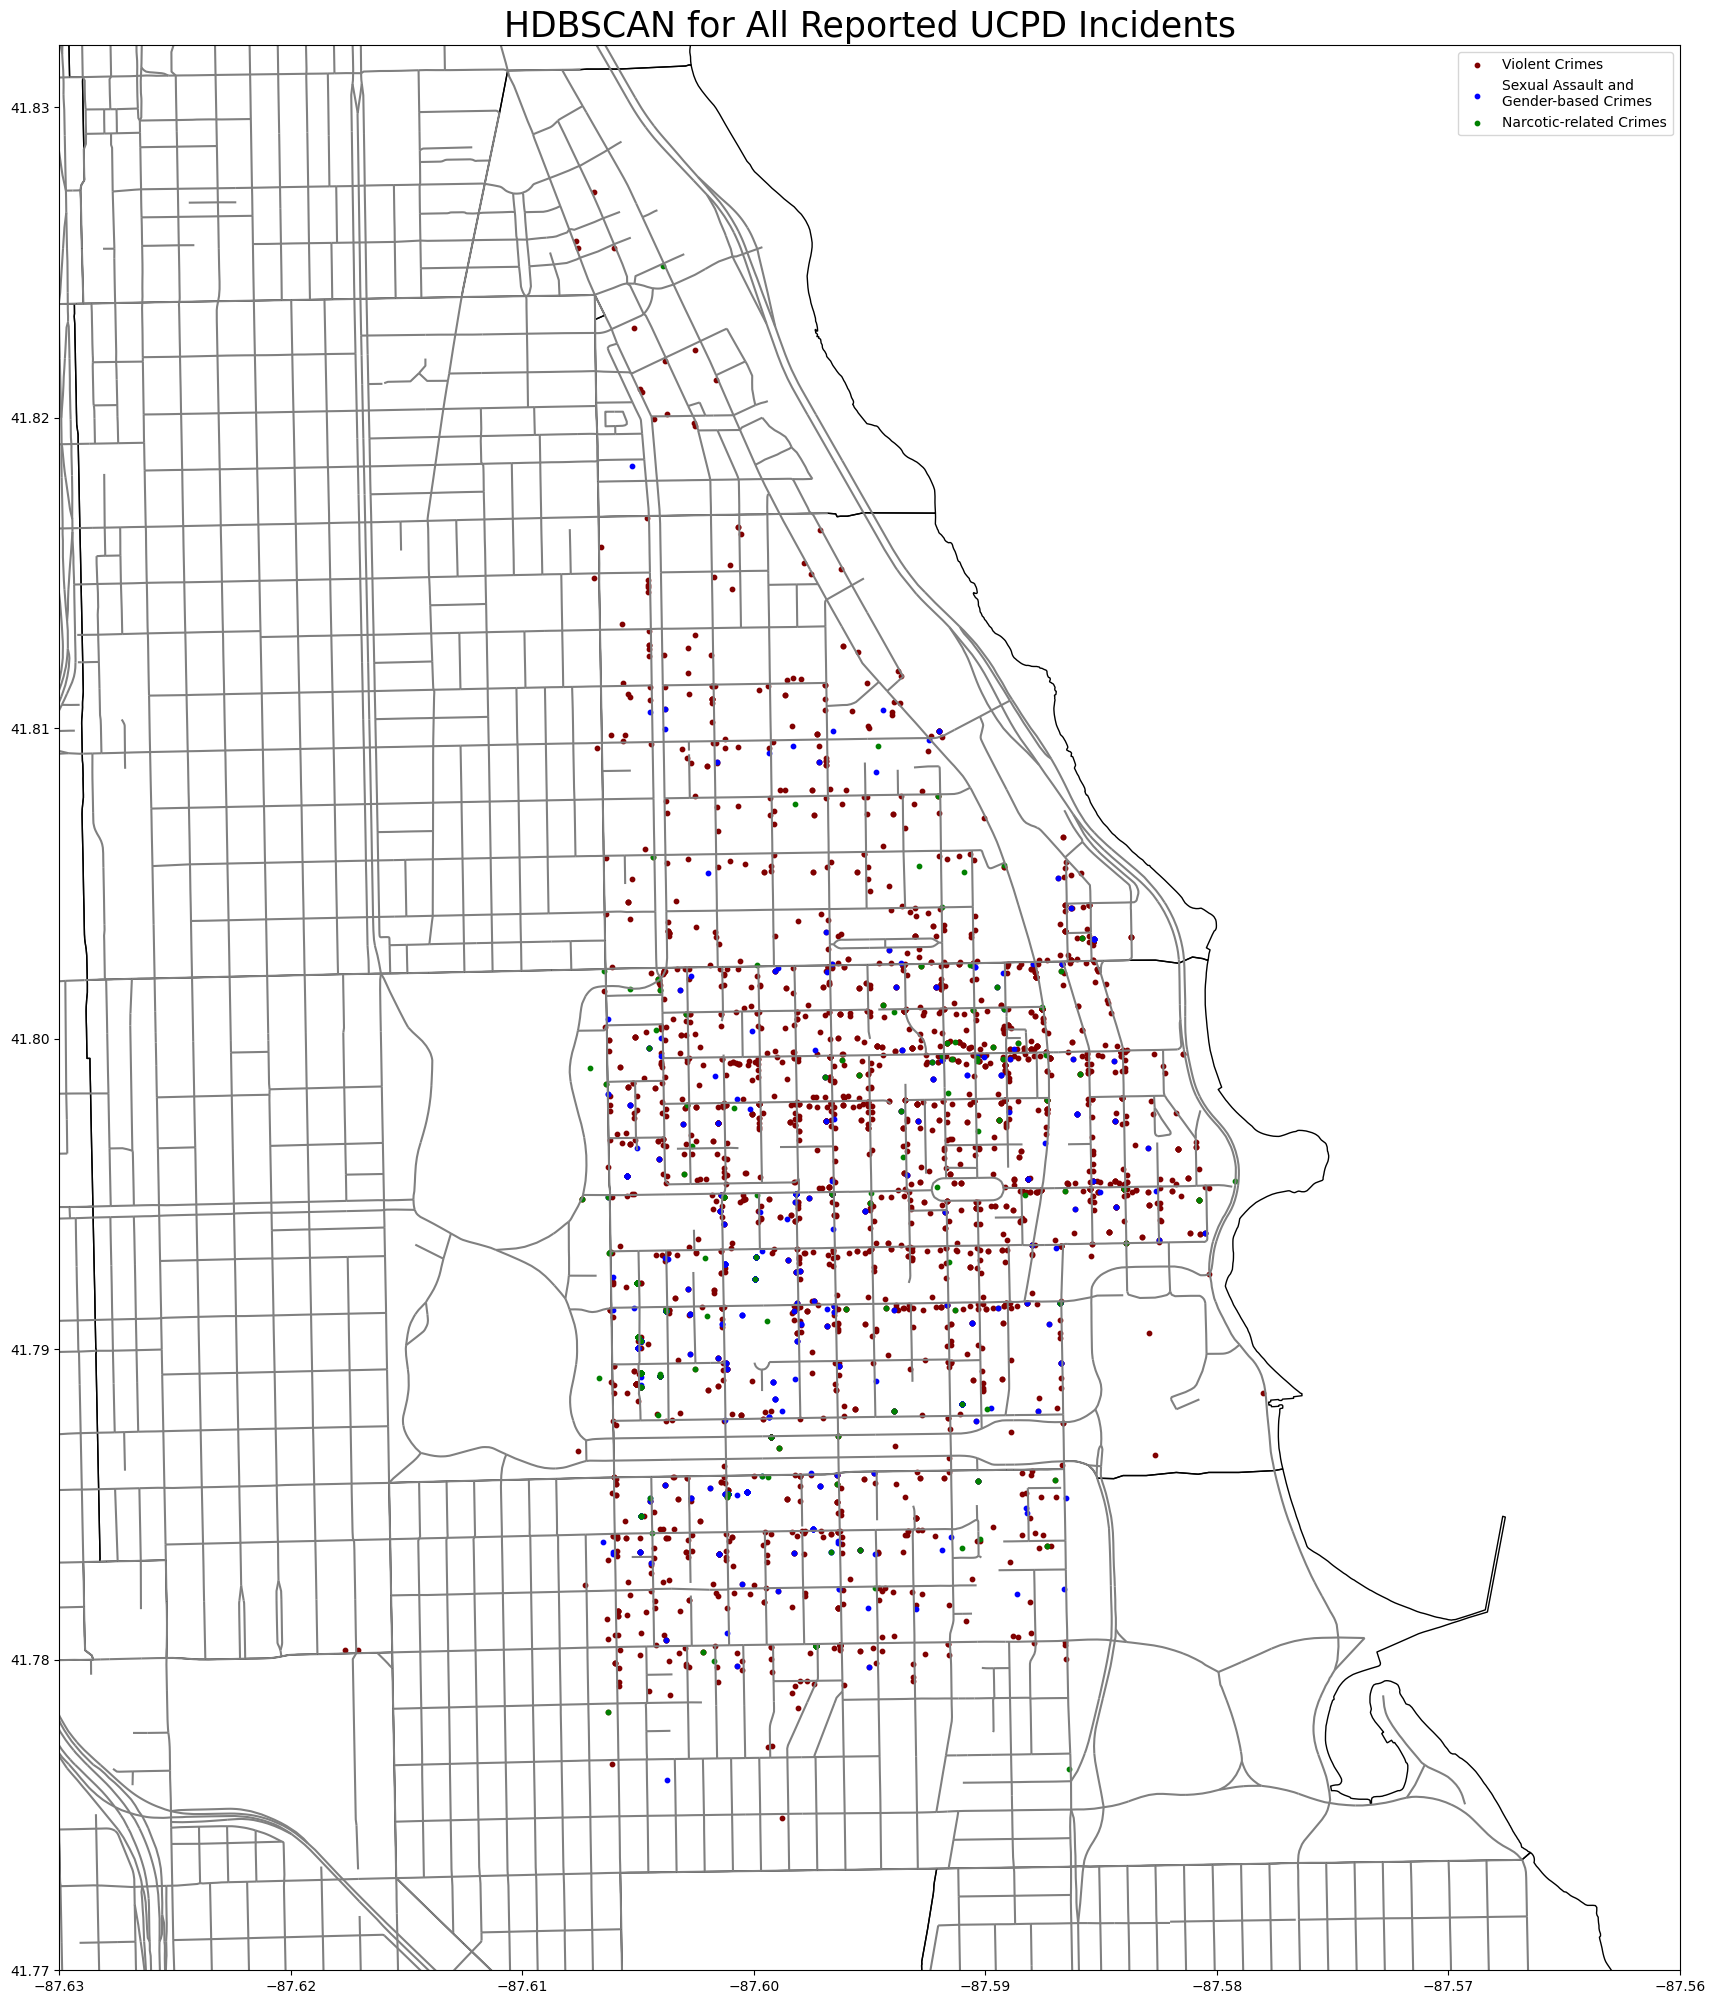

In [14]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)
chi_communities.to_crs(epsg=ESPG_NUM).plot(
    ax=ax, color="none", edgecolor="black"
)
chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=ax, color="grey")
ax.set_xlim(*VIEWPORT_X)
ax.set_ylim(*VIEWPORT_Y)
violence["All"].plot(
    ax=ax, markersize=10, color="maroon", label="Violent Crimes"
)
sa_gb["All"].plot(
    ax=ax,
    markersize=10,
    color="blue",
    label="Sexual Assault and\nGender-based Crimes",
)
narcotics["All"].plot(
    ax=ax, markersize=10, color="green", label="Narcotic-related Crimes"
)
plt.legend()
plt.title("HDBSCAN for All Reported UCPD Incidents", fontsize=25)
plt.savefig("all-crimes-overlap.png")

(2671, 2)
Estimated number of clusters for violent crimes: all seasons 2
Estimated number of noise points for violent crimes: all seasons 1703/2671


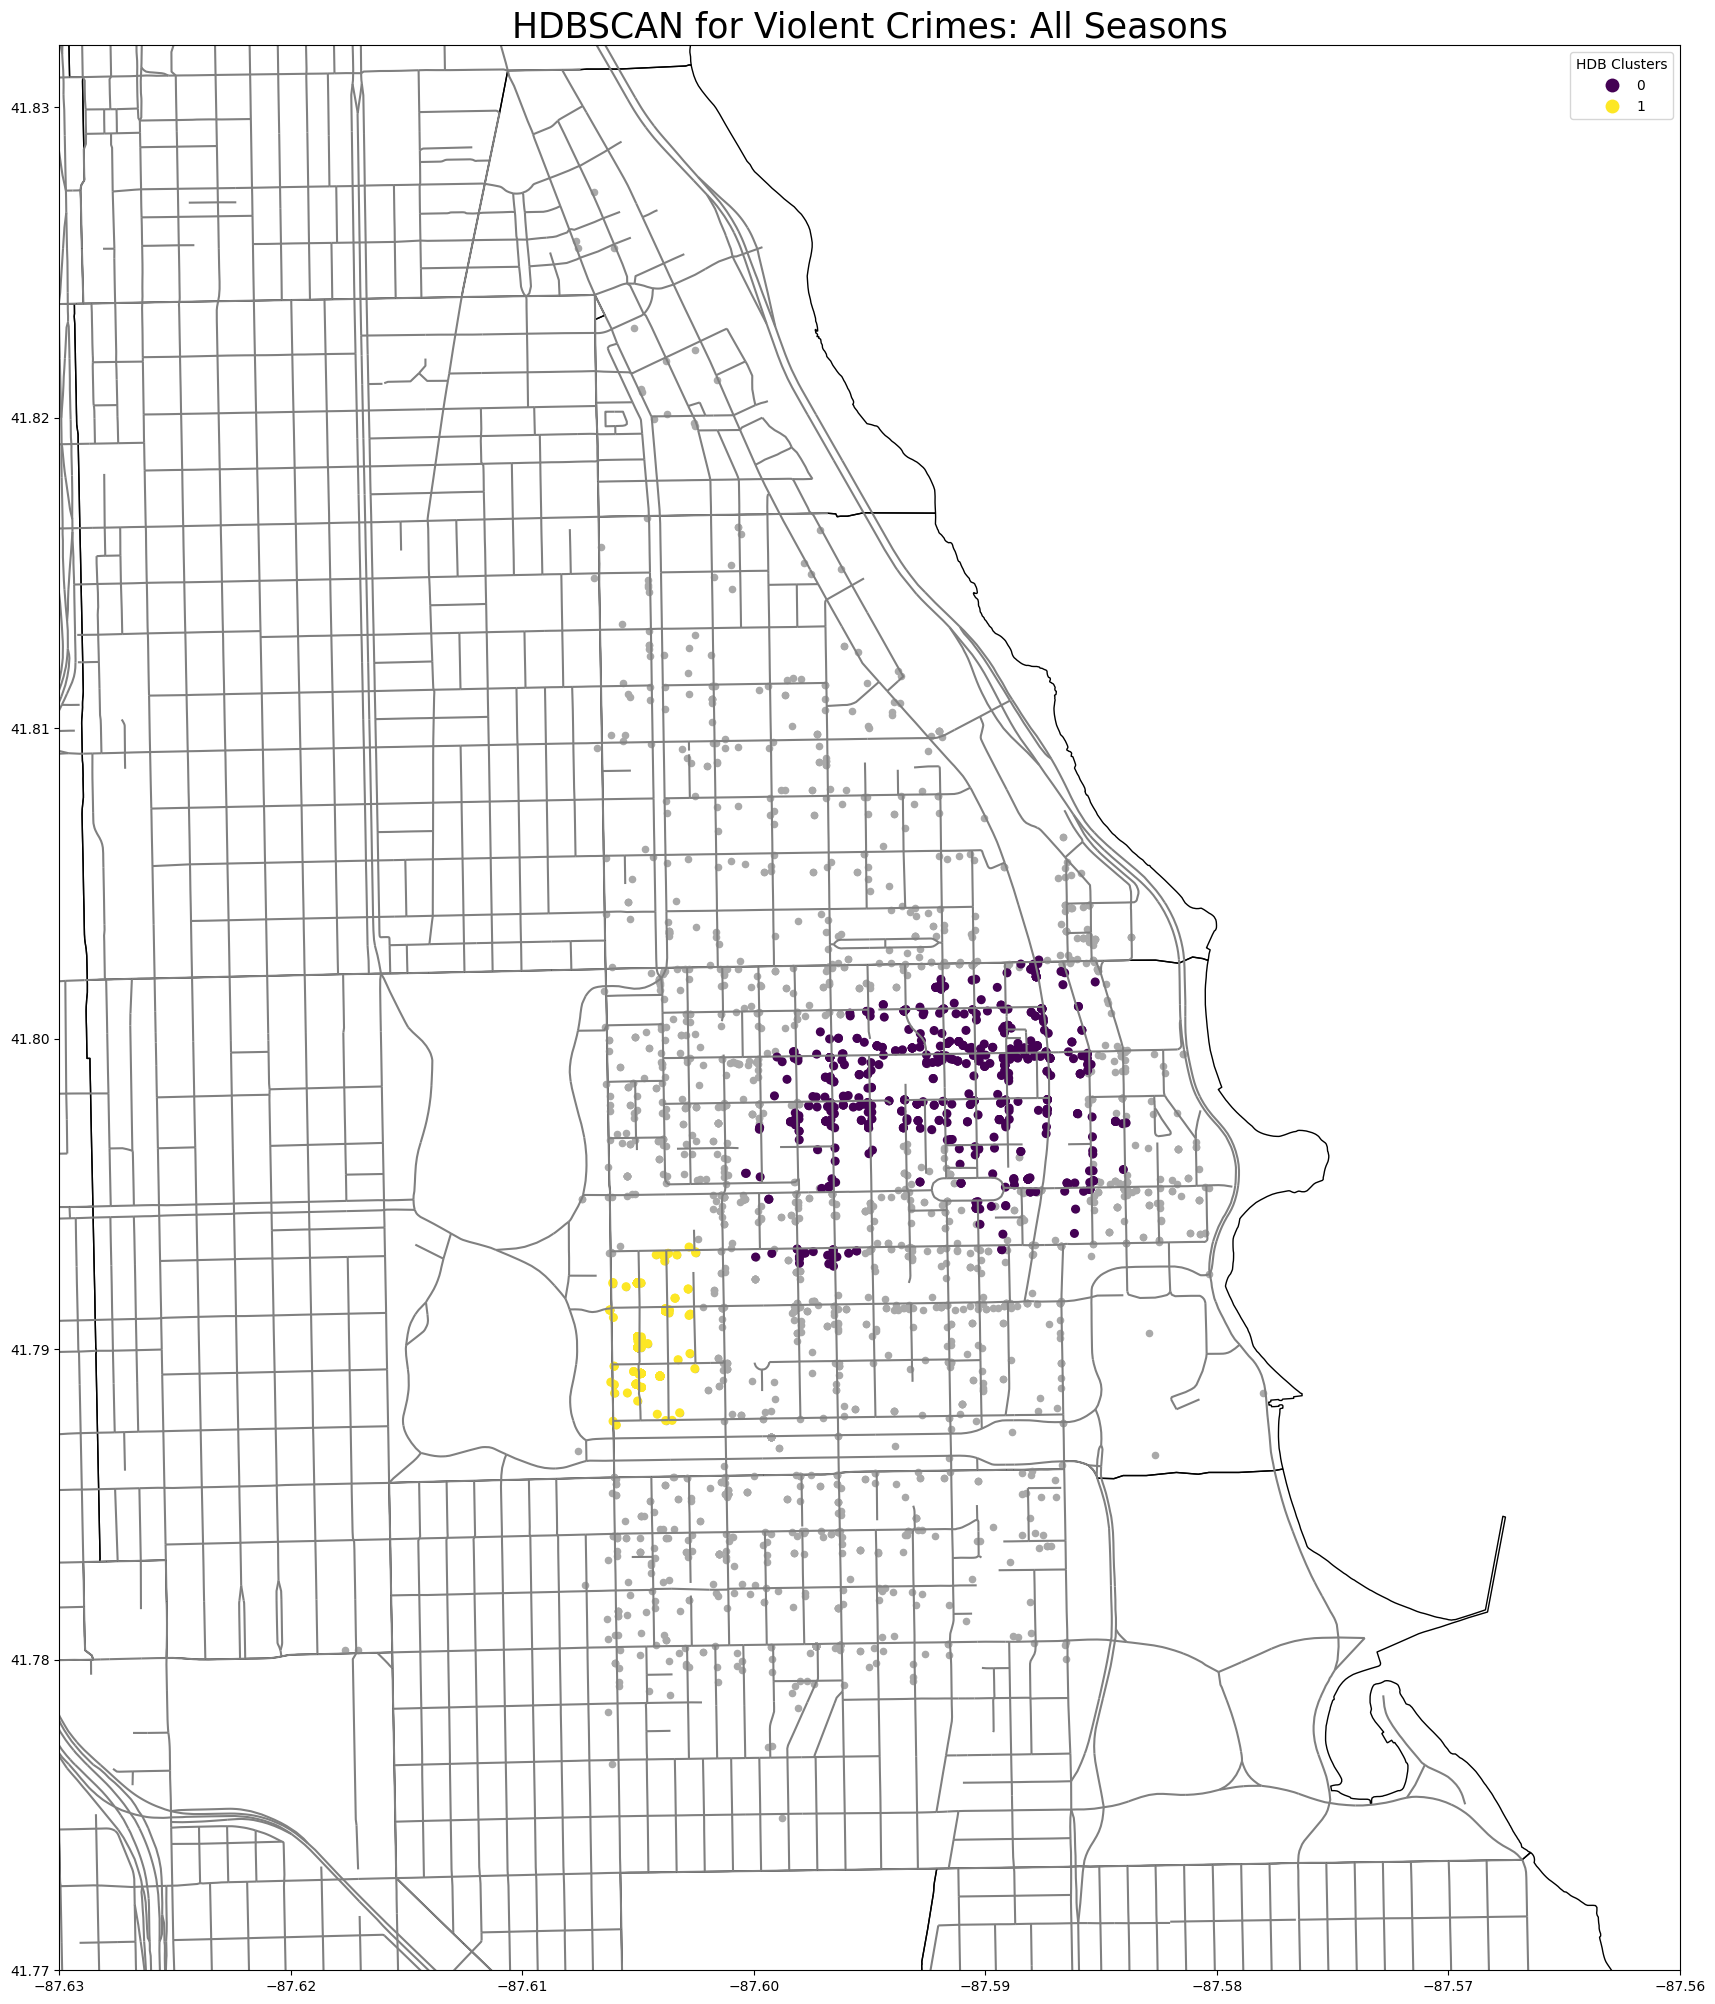

In [15]:
hdbscan_plotting(violence["All"], "violent crimes: all seasons")

(496, 2)
Estimated number of clusters for sexual assault and gender-based crimes: all seasons 8
Estimated number of noise points for sexual assault and gender-based crimes: all seasons 252/496


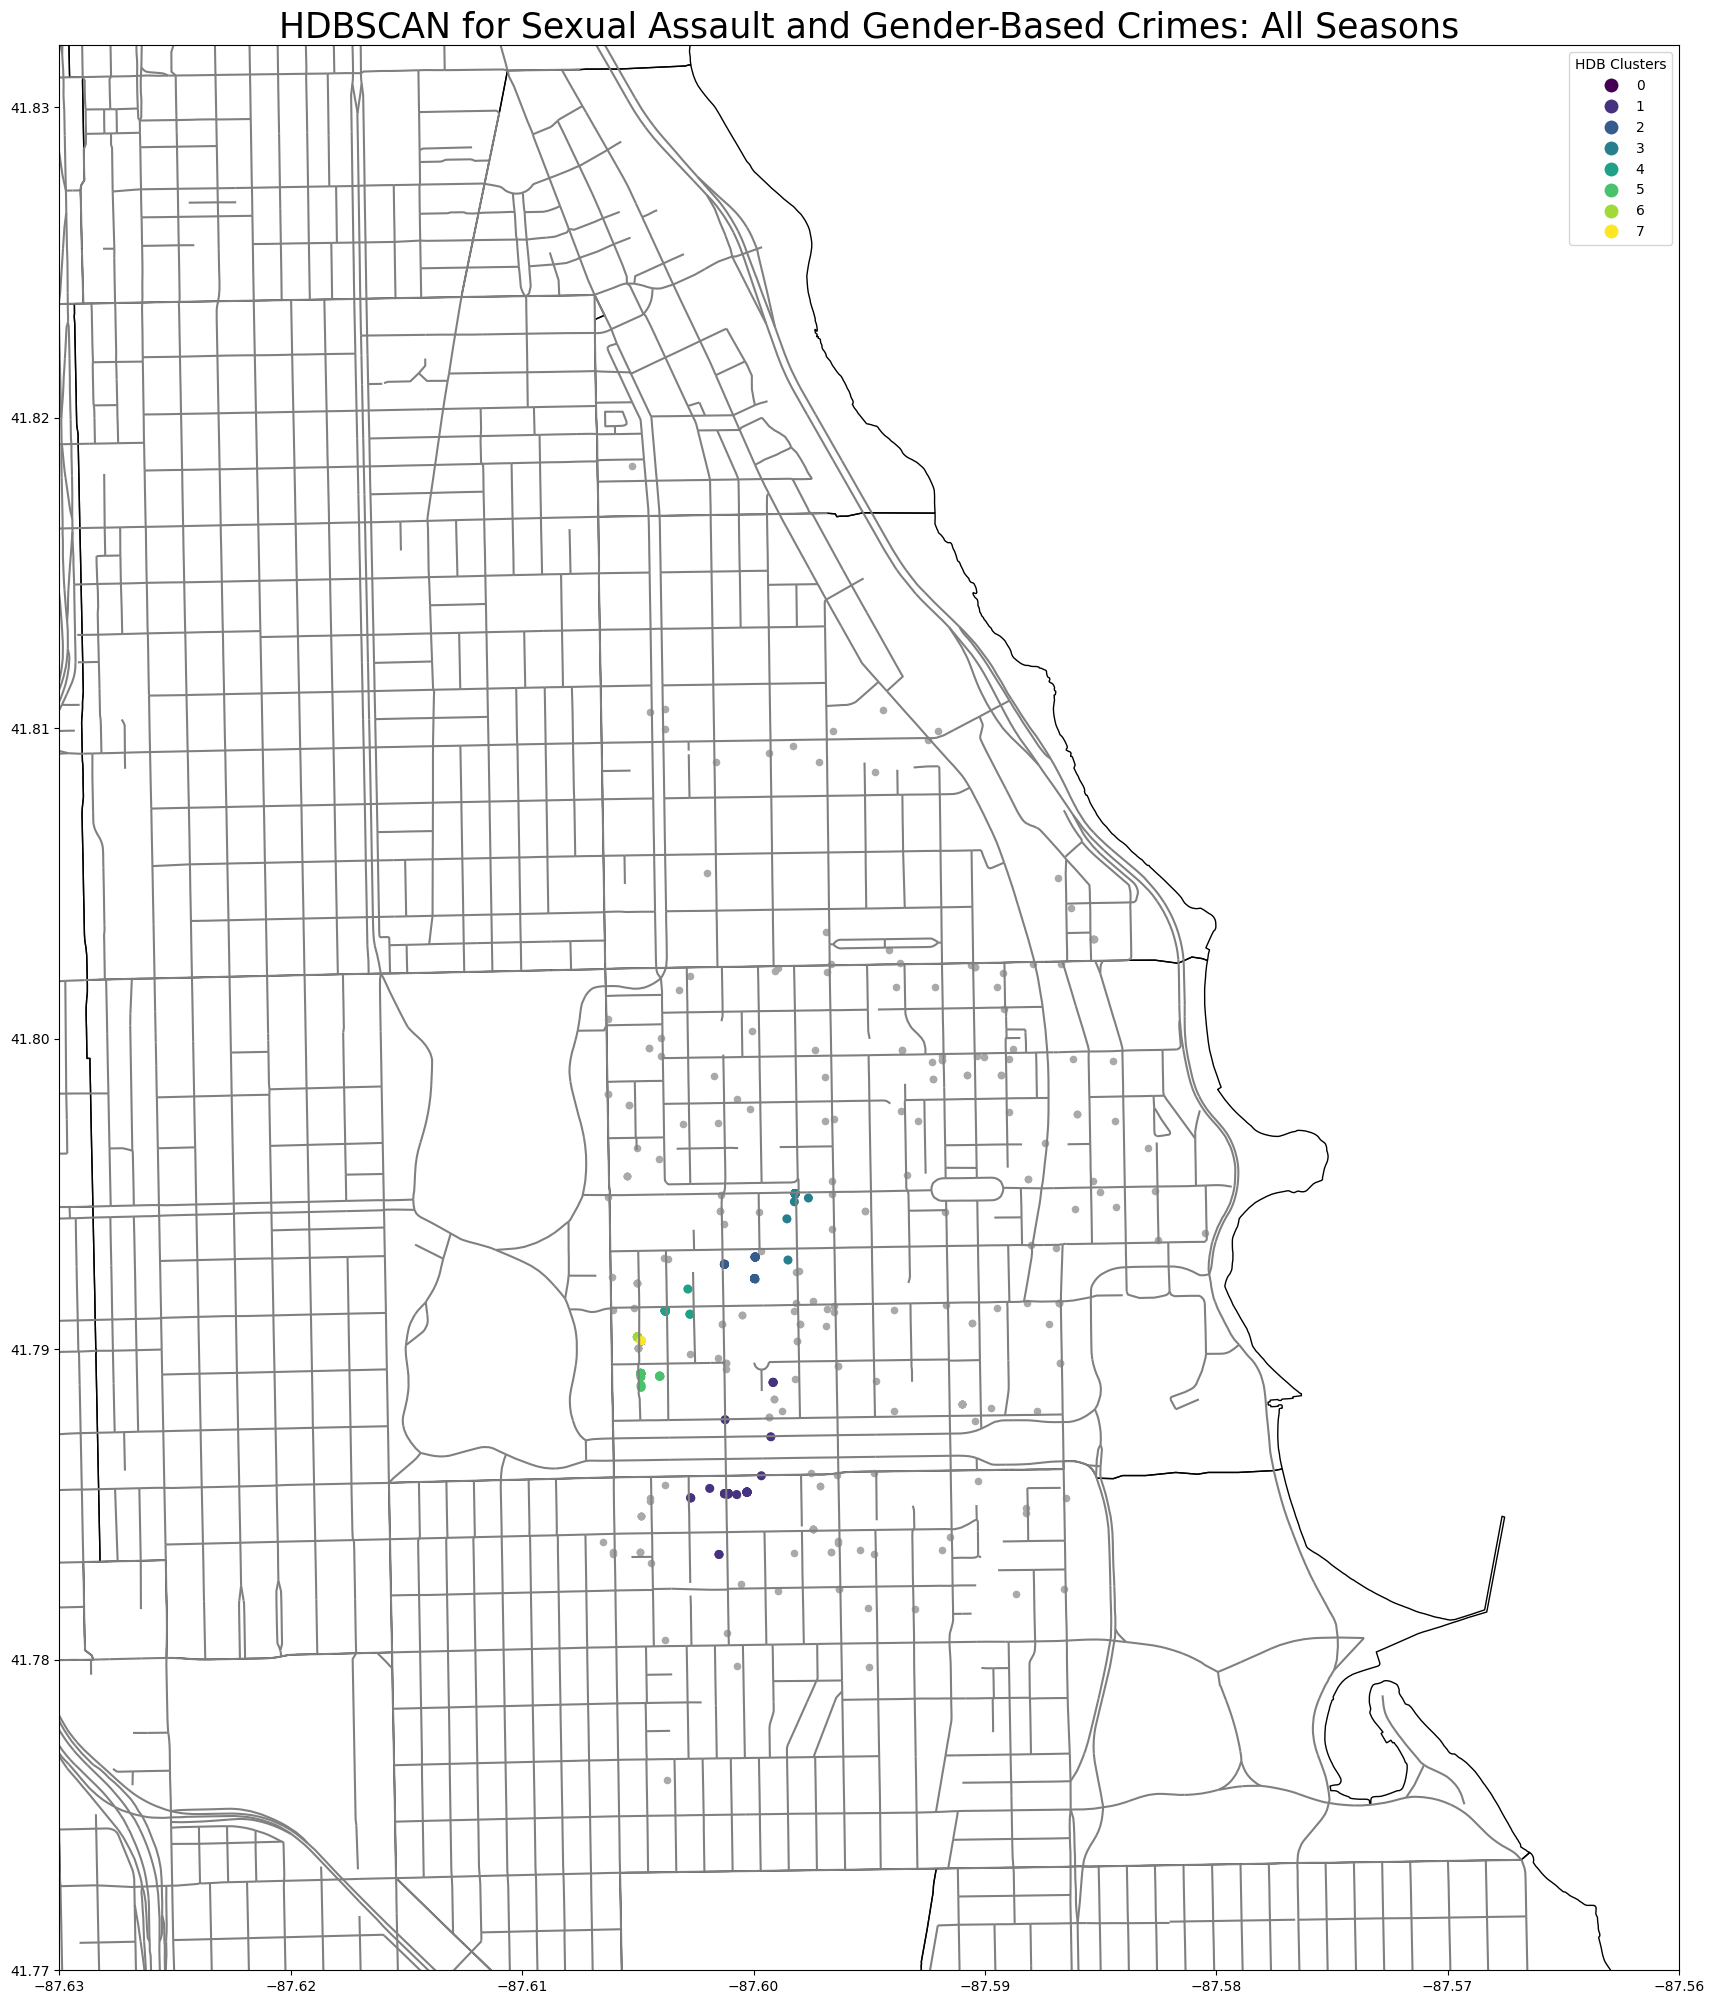

In [16]:
hdbscan_plotting(
    sa_gb["All"], "sexual assault and gender-based crimes: all seasons"
)

(319, 2)
Estimated number of clusters for narcotic-related crimes: all seasons 4
Estimated number of noise points for narcotic-related crimes: all seasons 101/319


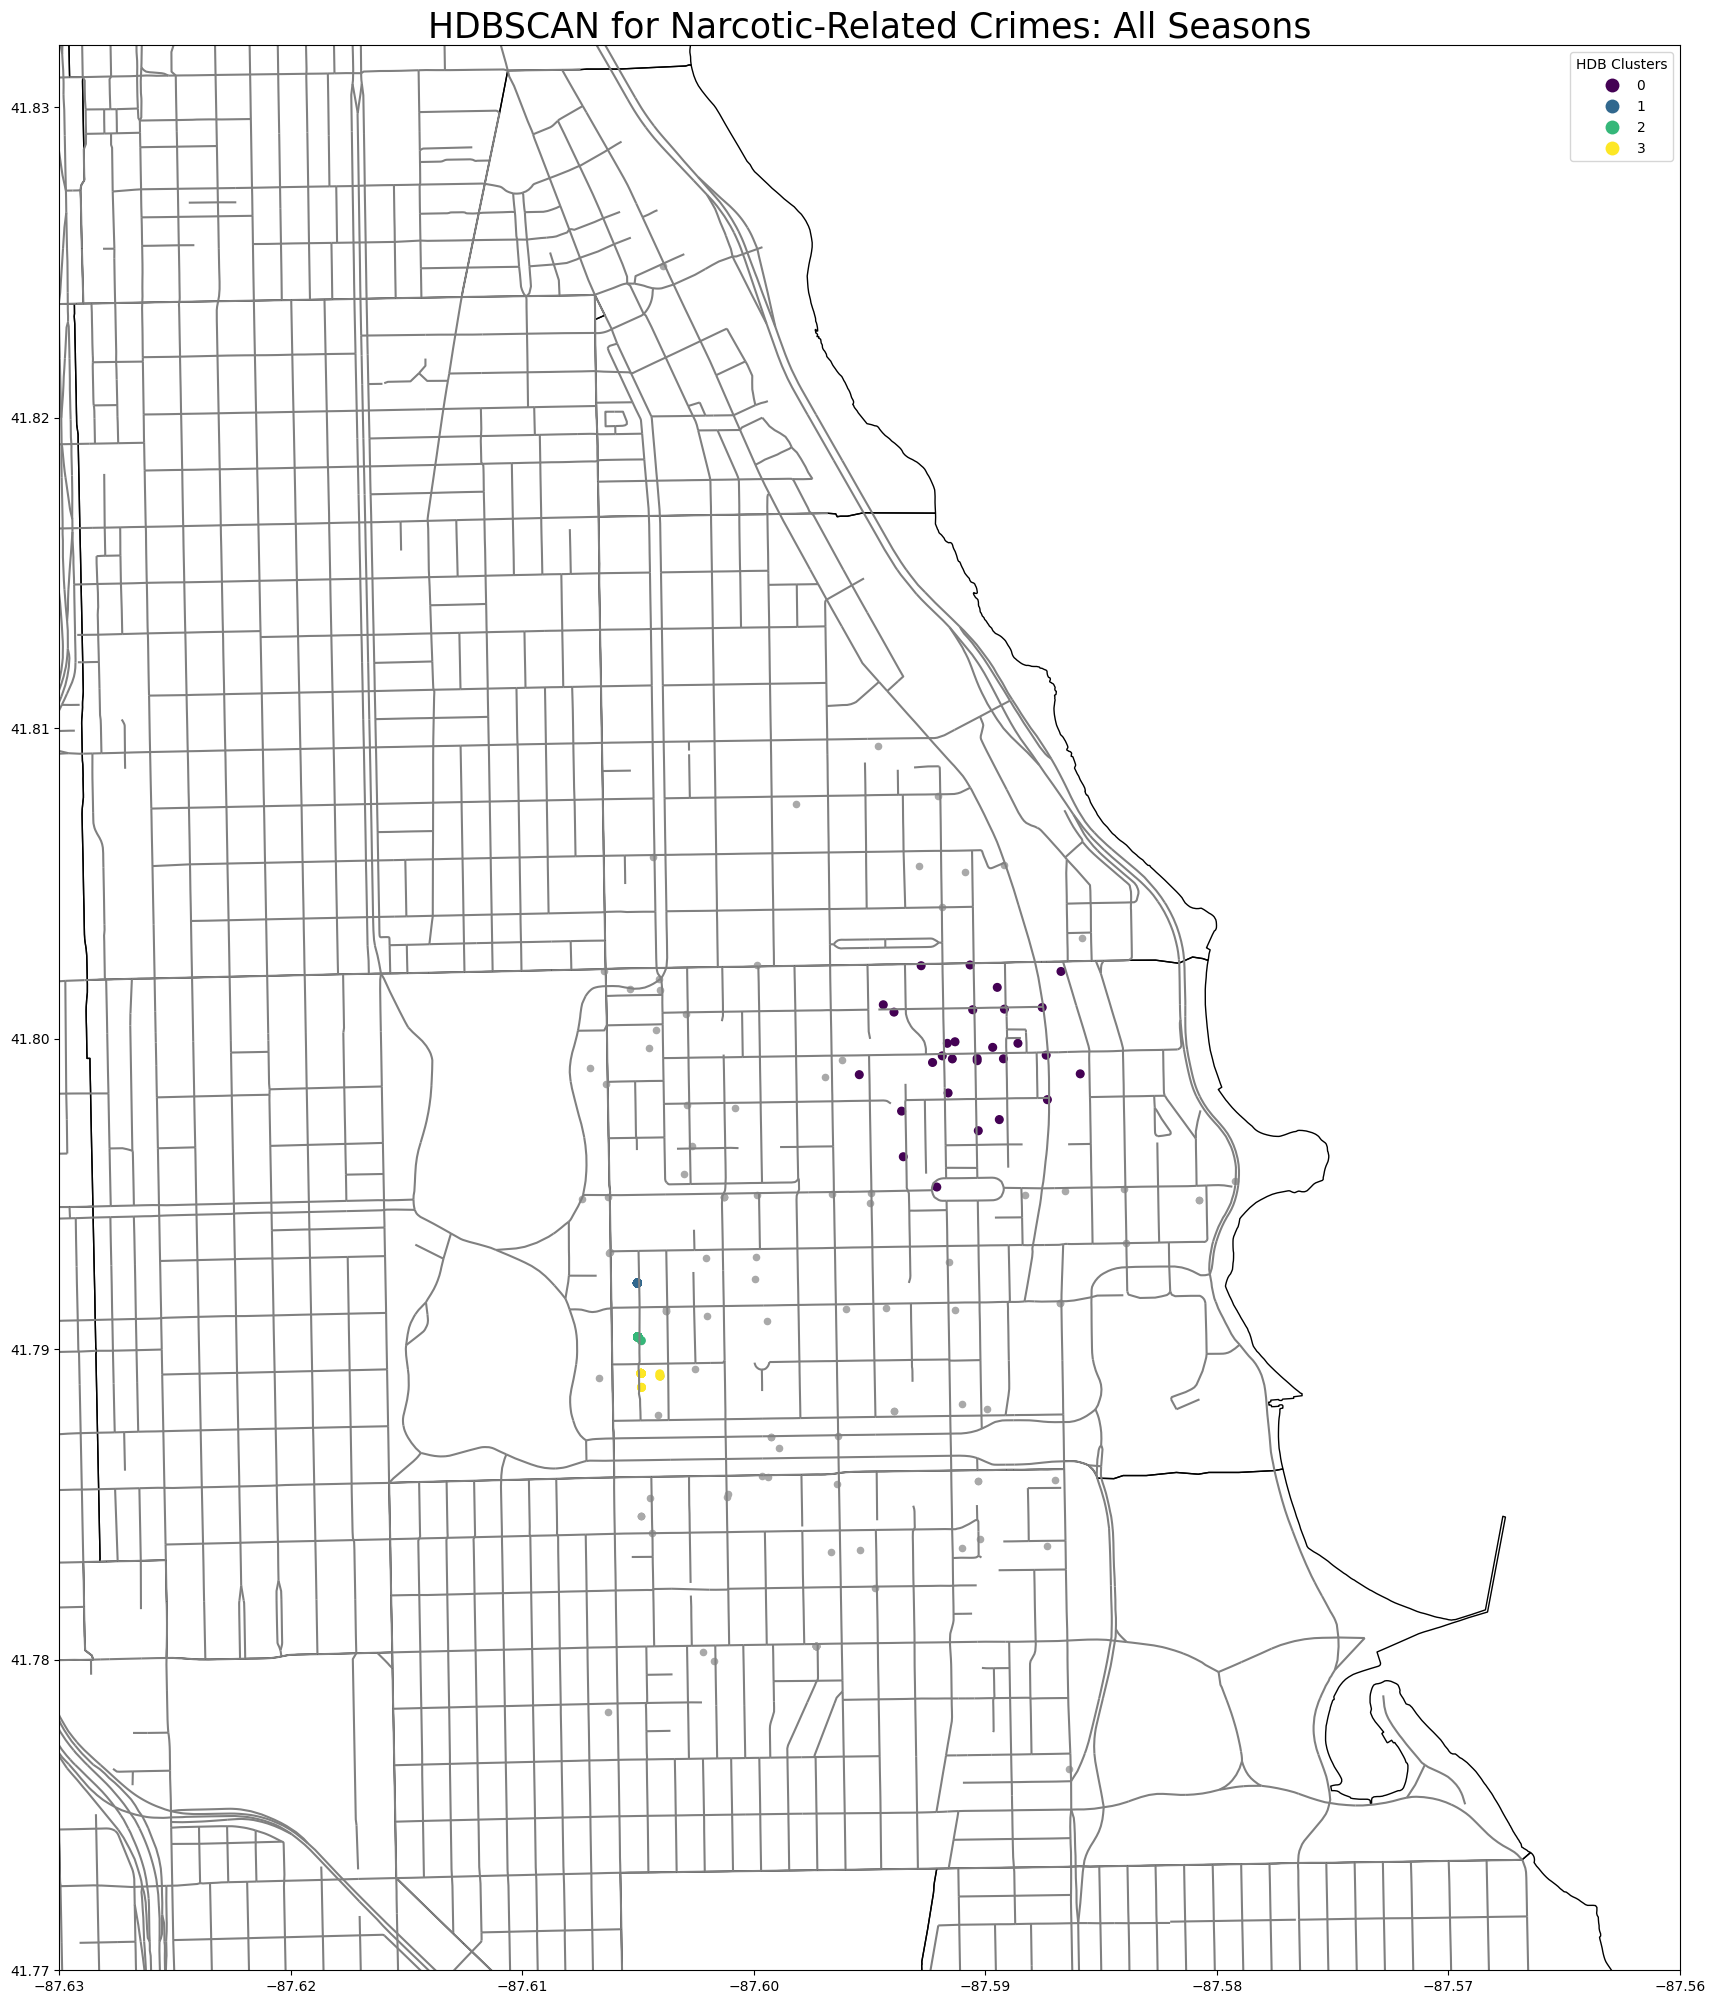

In [17]:
hdbscan_plotting(narcotics["All"], "narcotic-related crimes: all seasons")

In [305]:
def create_four_seasons_png(
    i_dict: {str: gp.GeoDataFrame}, category: str
) -> None:
    q_fig, q_ax = plt.subplots(2, 2, figsize=FIGURE_SIZE)

    q_fig.subplots_adjust(top=0.94)
    for qx in q_ax.flat:
        chi_communities.to_crs(epsg=ESPG_NUM).plot(
            ax=qx, color="none", edgecolor="black", zorder=1
        )
        chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=qx, color="grey", zorder=2)
        qx.set_xlim(*VIEWPORT_X)
        qx.set_ylim(*VIEWPORT_Y)

    # Spring Image
    spring_df = i_dict["Spring"][i_dict["Spring"].hdb_cluster != "-1"]
    i_dict["Spring"].plot(
        ax=q_ax[0, 0], markersize=5, color="darkgrey", zorder=3
    )
    spring_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[0, 0],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[0, 0].set_title(f"HDBSCAN Clusters for {category} Crimes: Spring")

    # Summer Image
    summer_df = i_dict["Summer"][i_dict["Summer"].hdb_cluster != "-1"]
    i_dict["Summer"].plot(
        ax=q_ax[0, 1], markersize=5, color="darkgrey", zorder=3
    )
    summer_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[0, 1],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[0, 1].set_title(f"HDBSCAN Clusters for {category} Crimes: Summer")

    # Fall Image
    fall_df = i_dict["Fall"][i_dict["Fall"].hdb_cluster != "-1"]
    i_dict["Fall"].plot(ax=q_ax[1, 0], markersize=5, color="darkgrey", zorder=3)
    fall_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[1, 0],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[1, 0].set_title(f"HDBSCAN Clusters for {category} Crimes: Fall")

    # Winter Image
    winter_df = i_dict["Winter"][i_dict["Winter"].hdb_cluster != "-1"]
    i_dict["Winter"].plot(
        ax=q_ax[1, 1], markersize=5, color="darkgrey", zorder=3
    )
    winter_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[1, 1],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[1, 1].set_title(f"HDBSCAN Clusters for {category} Crimes: Winter")

    q_fig.suptitle(f"Seasonal HDBSCANs for {category} Crimes", fontsize=25)

    plt.savefig(f"{category.lower()}-seasons.png")

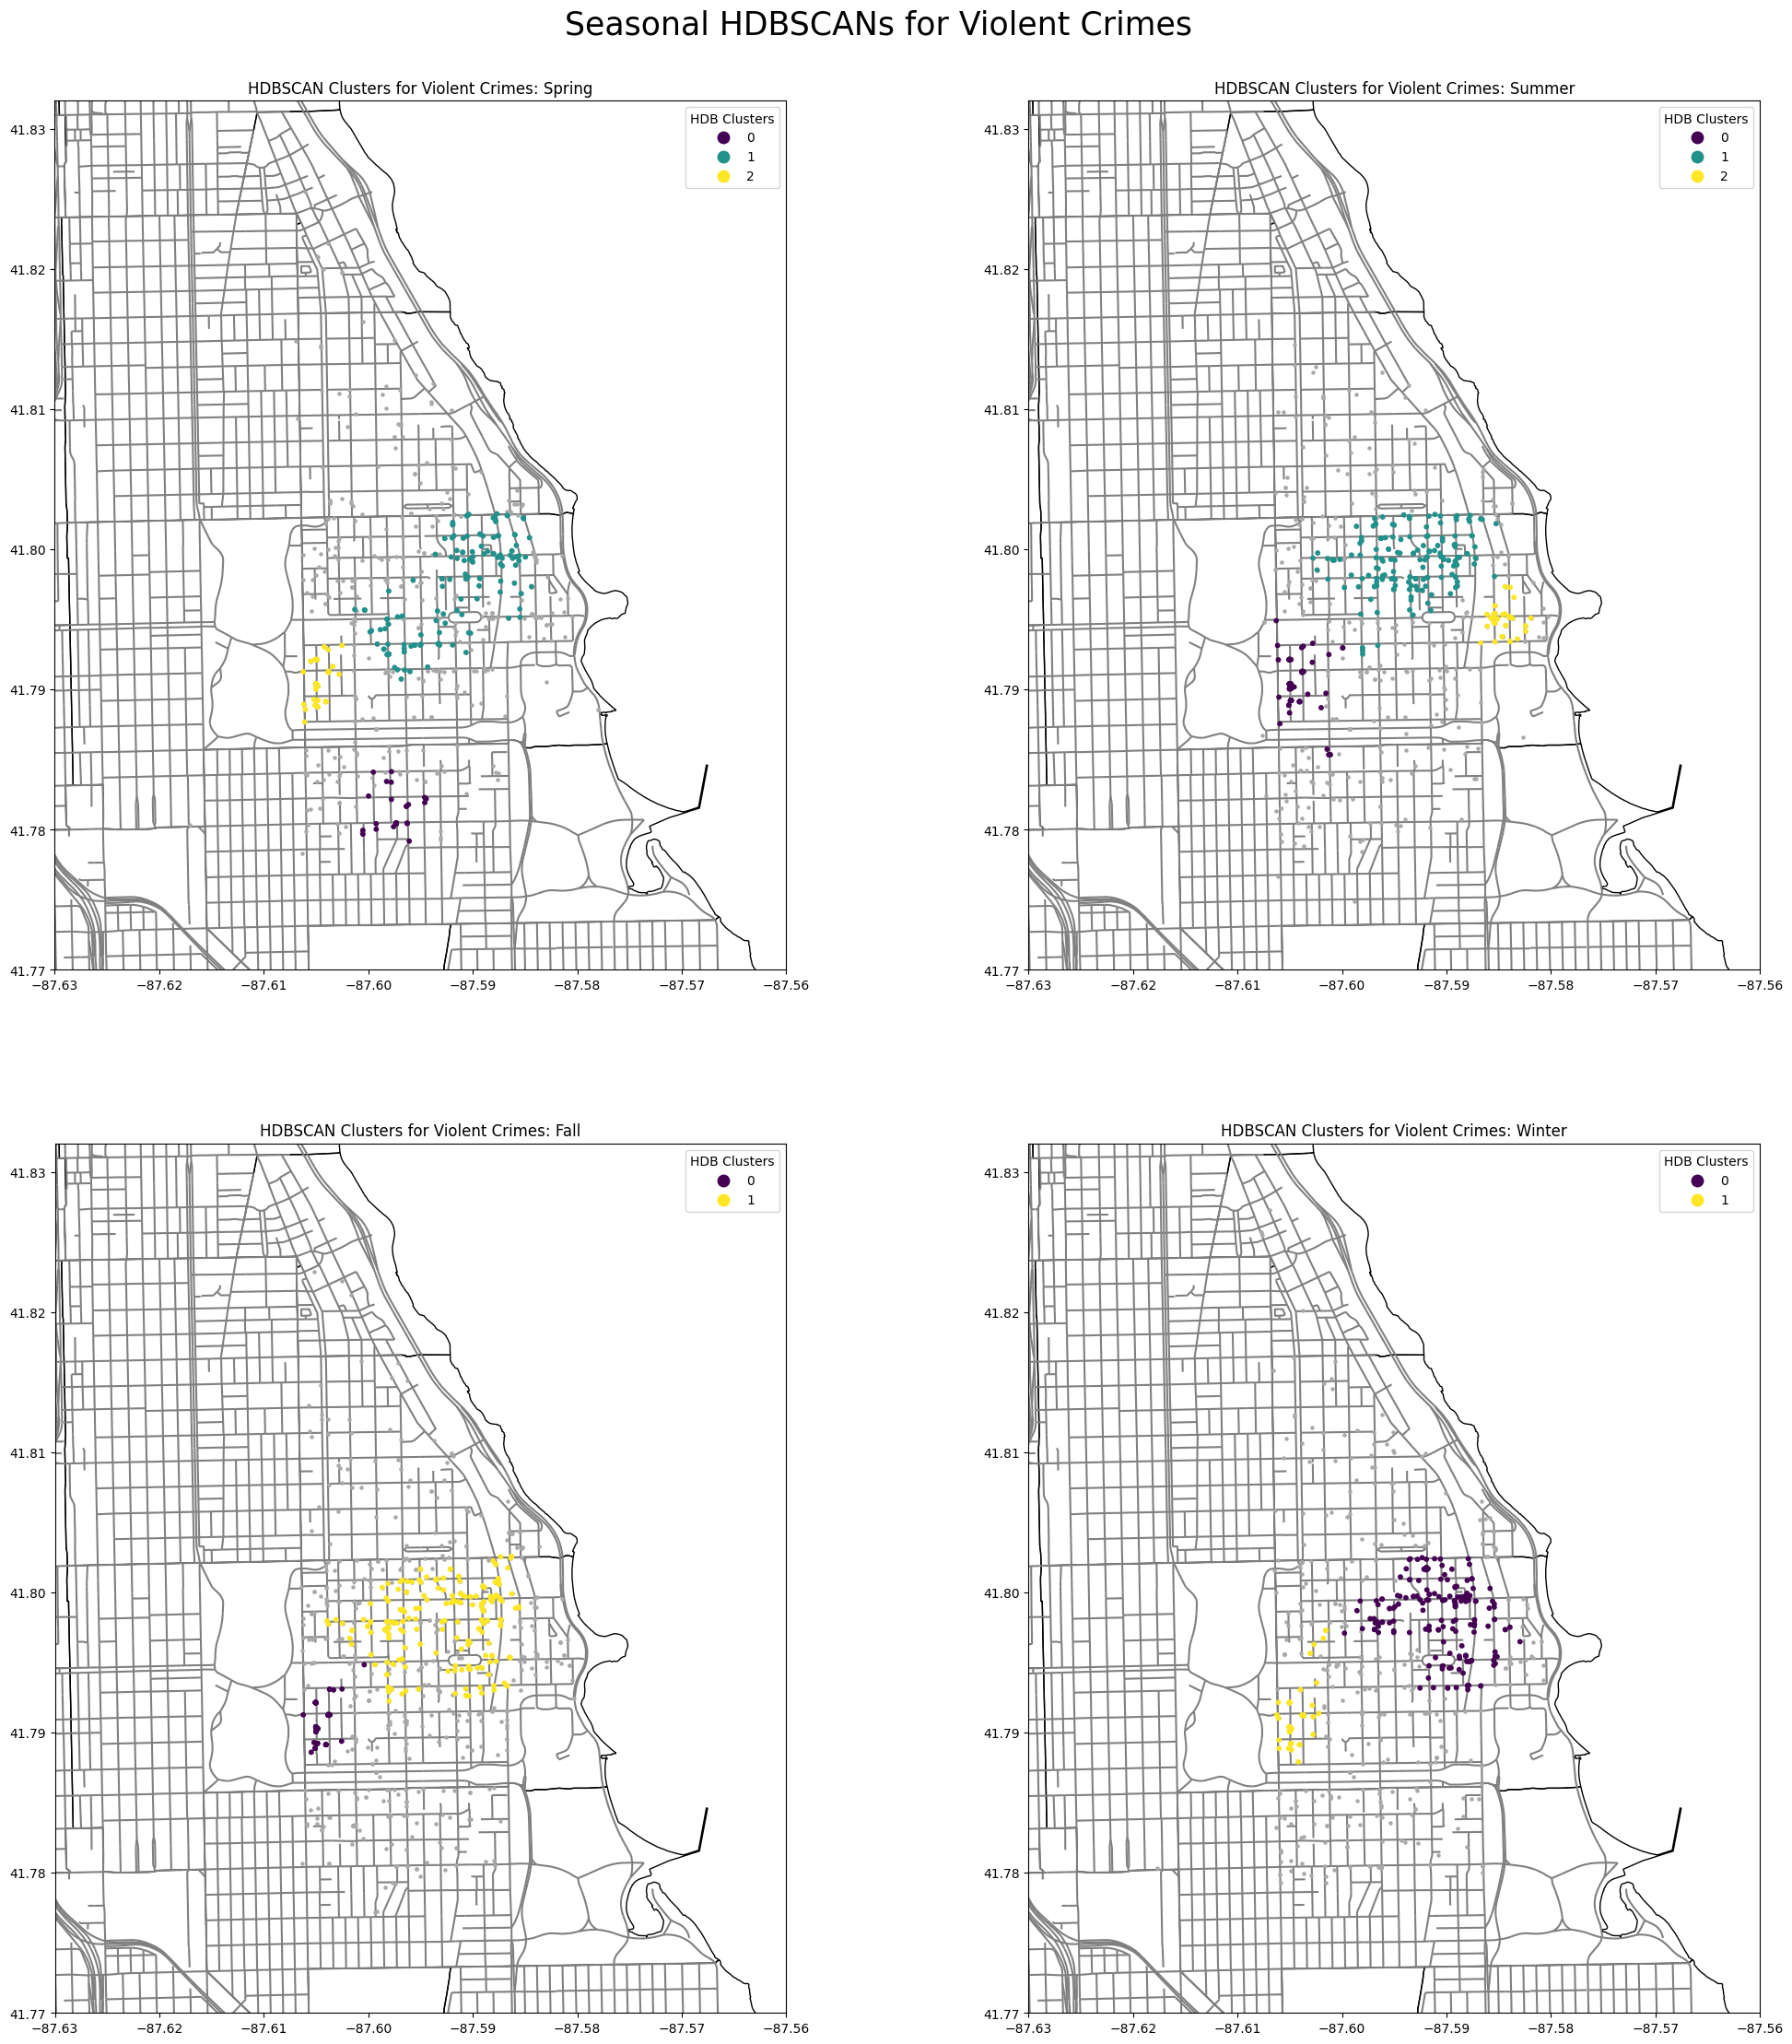

In [306]:
create_four_seasons_png(violence, "Violent")

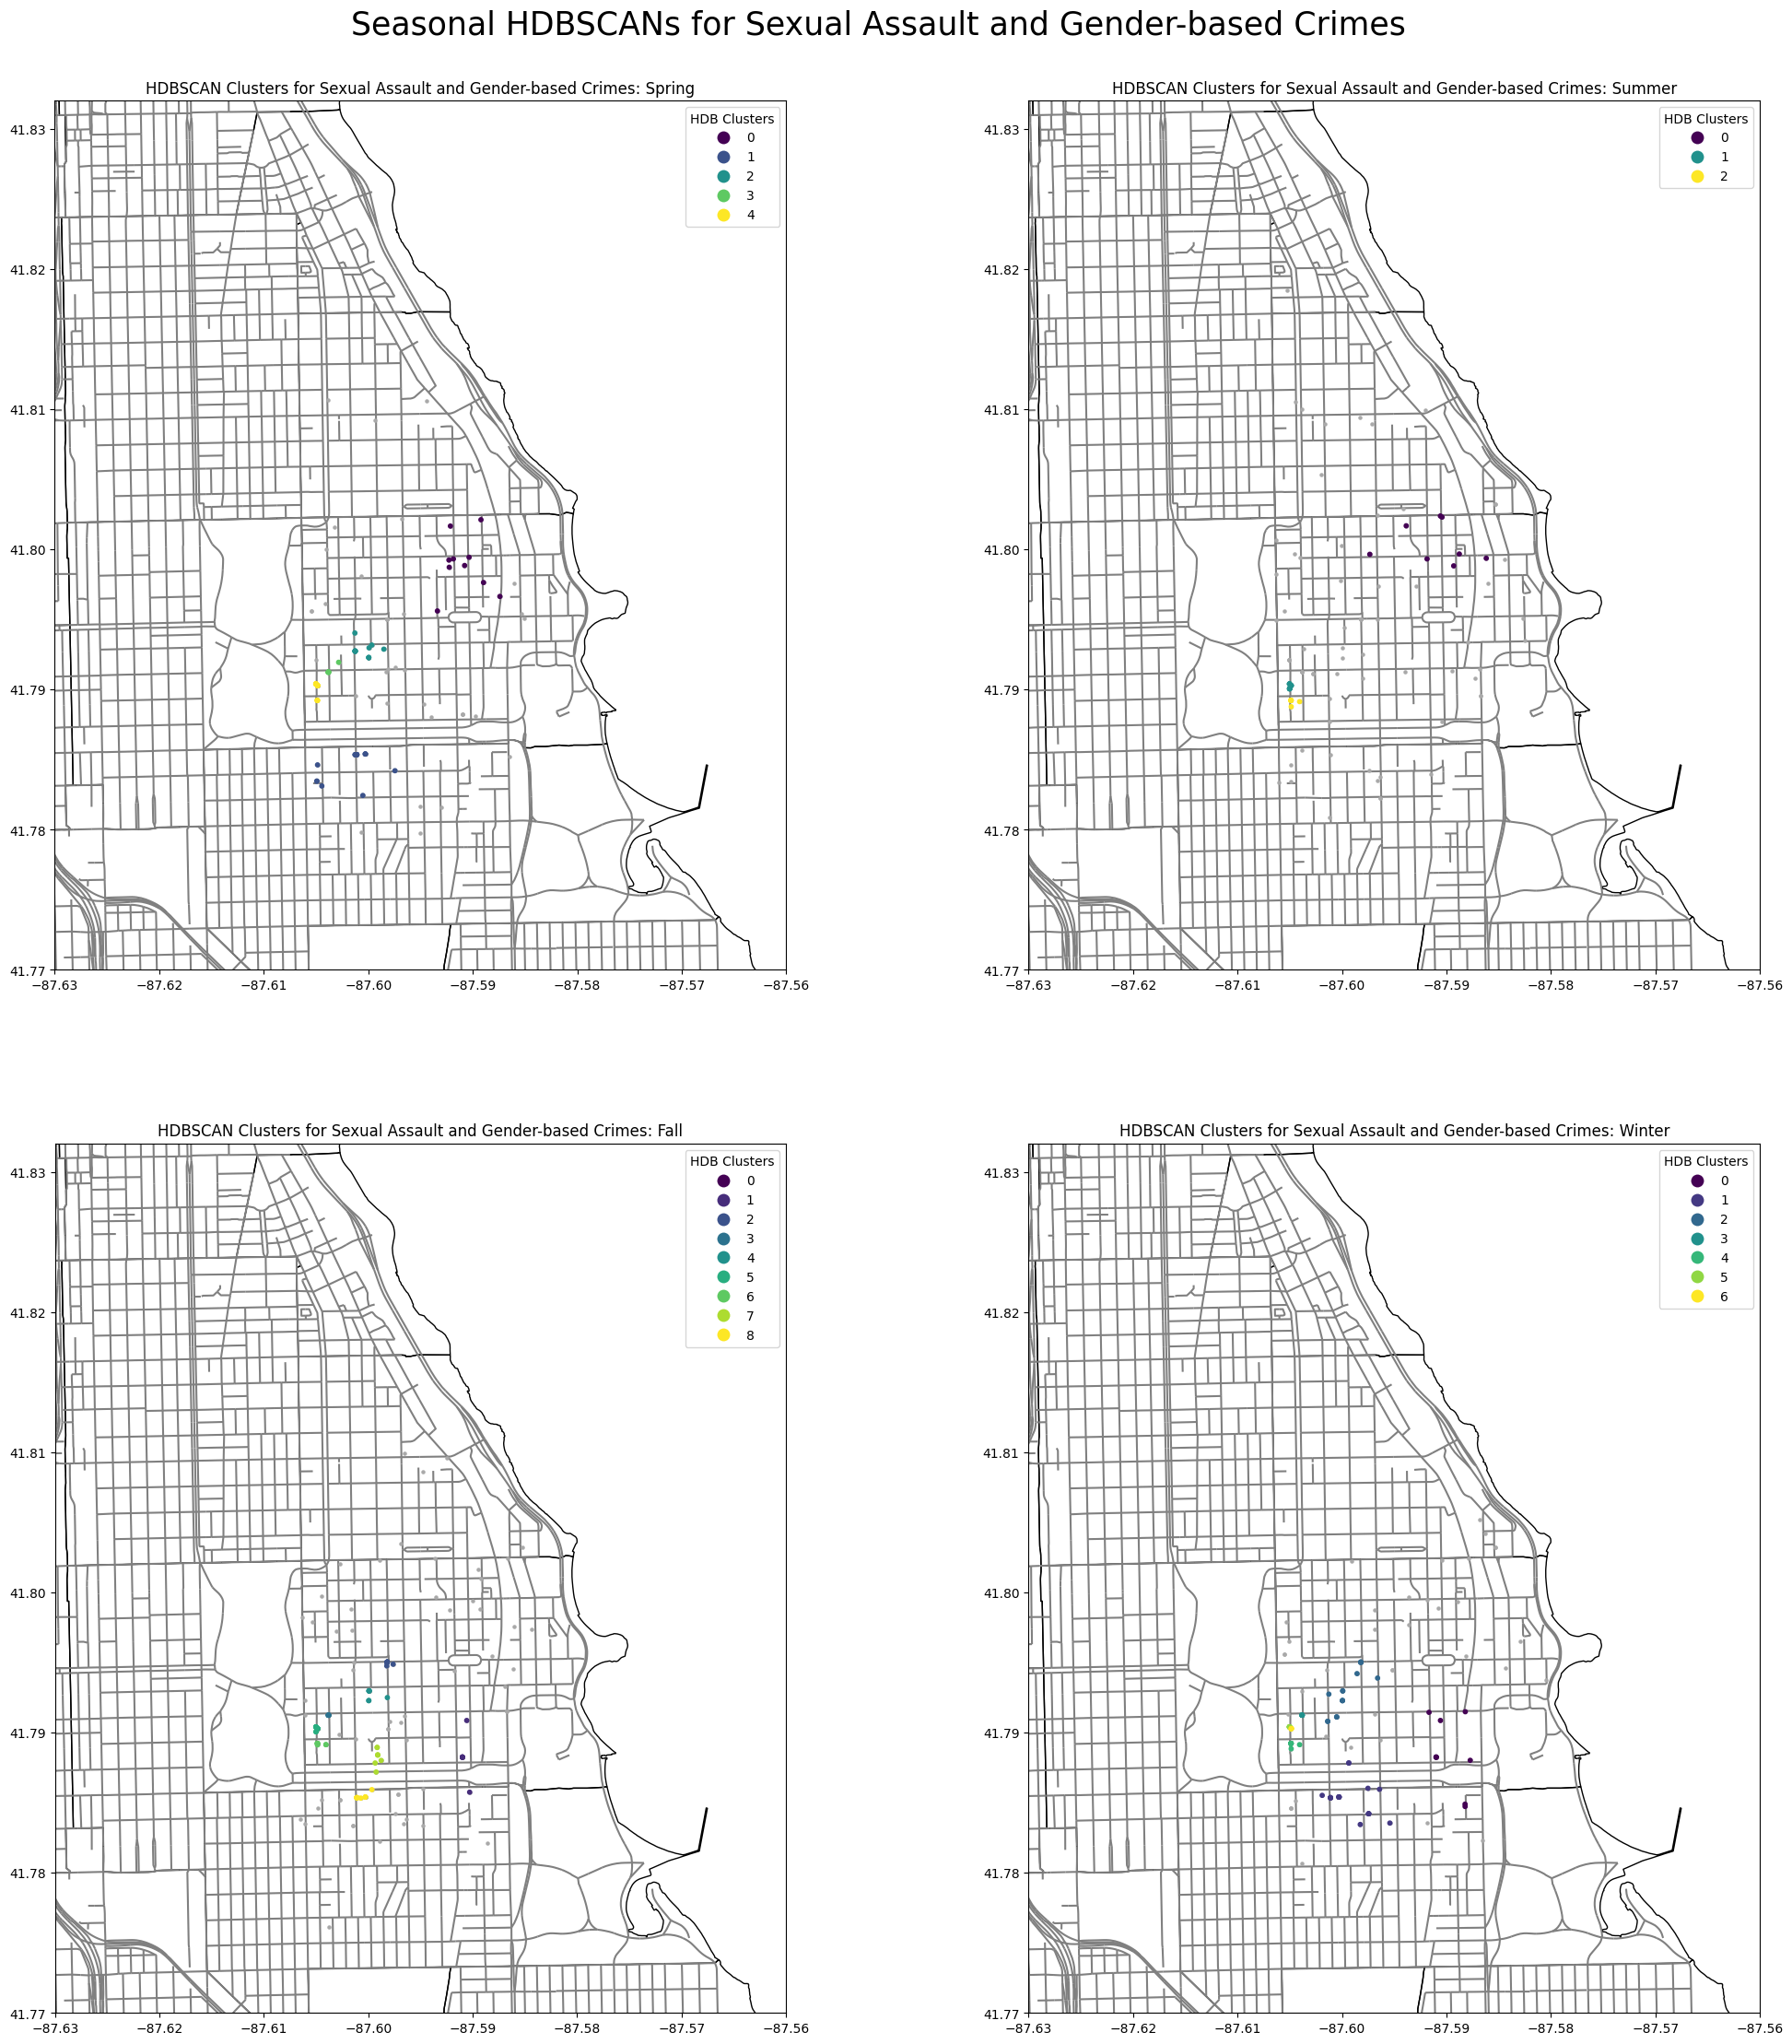

In [307]:
create_four_seasons_png(sa_gb, "Sexual Assault and Gender-based")

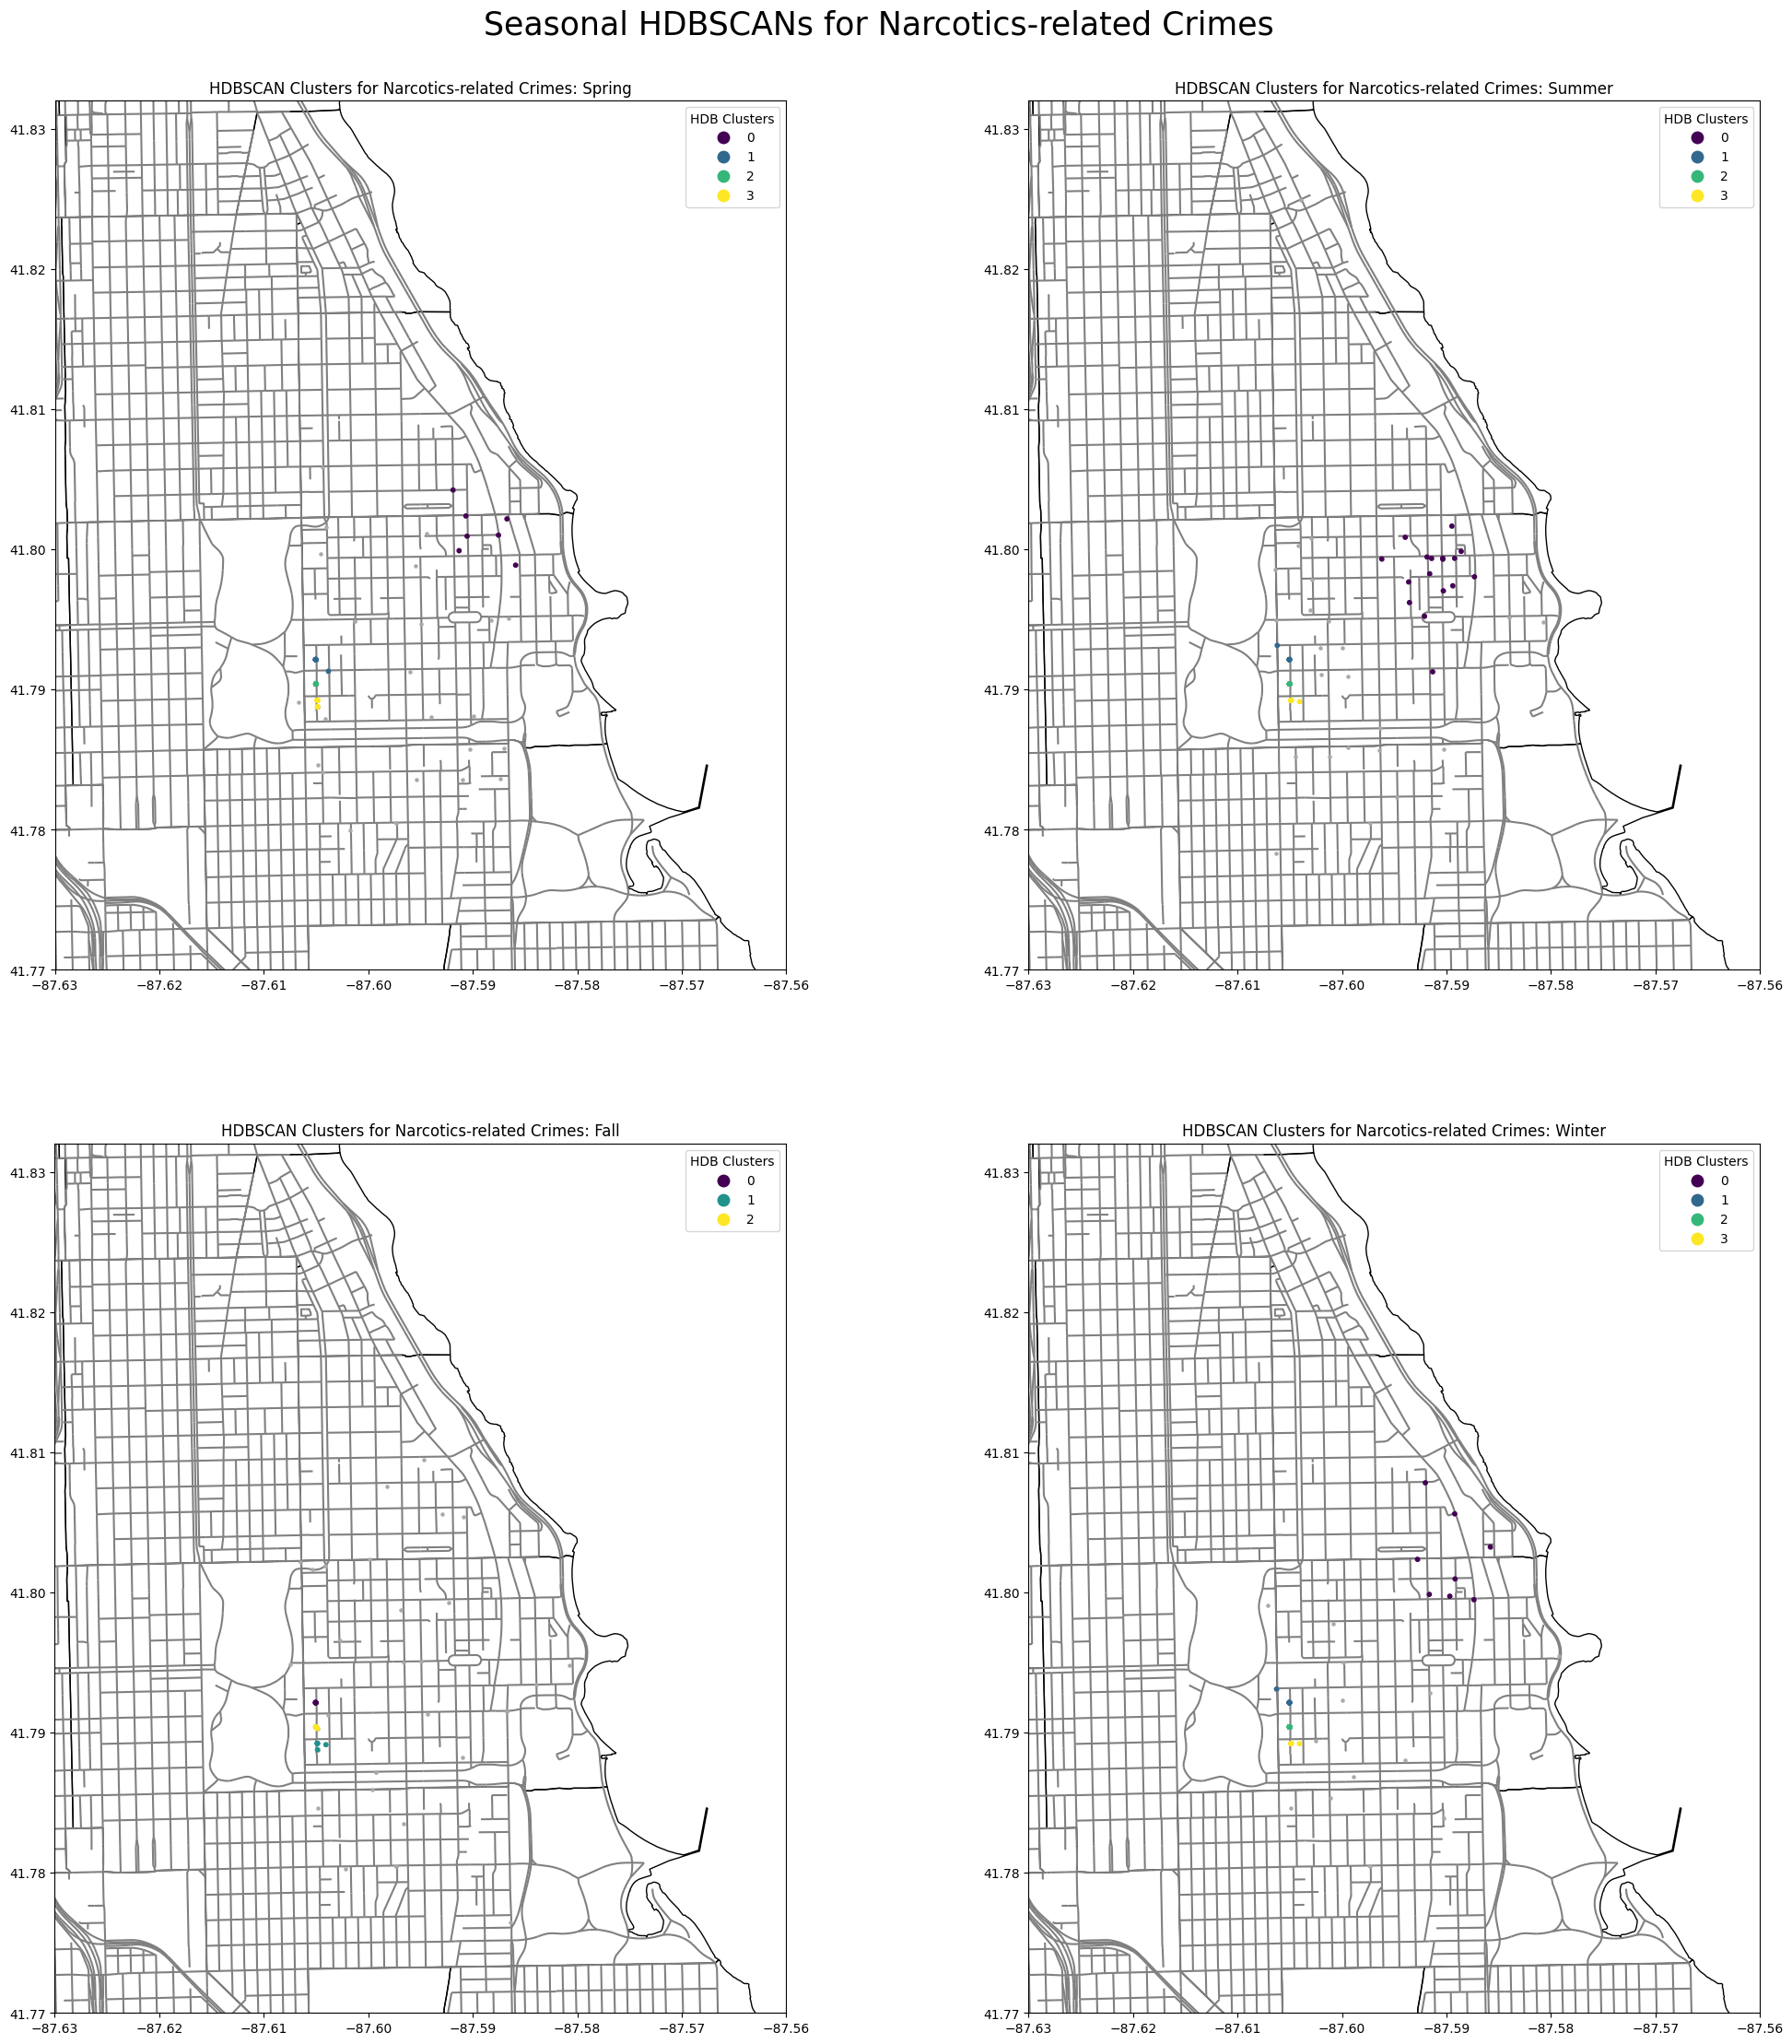

In [308]:
create_four_seasons_png(narcotics, "Narcotics-related")